In [69]:
import os, sys, re, json, time
from importlib import reload
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import *
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import tensorflow as tf
from IPython.display import display, clear_output 
import time
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report

# Load the IBC Sentences - Assign Binary Liberal/Conservative Labels

In [70]:
ibc_frame=pd.read_csv('full_ibc_sentences.csv')
ibc_frame=ibc_frame.loc[ibc_frame['label']!='Neutral']
ibc_values_dict={'Liberal':0,'Conservative':1}

ibc_frame['class']=ibc_frame['label'].map(ibc_values_dict)
sentences=ibc_frame['sentence'].as_matrix()
labels=ibc_frame['class'].as_matrix()

# Load Weak Annotations for IBC Sentences

In [71]:
reddit_labels = pd.read_csv('IBC_weak_labels_conlibonly.csv')
print(reddit_labels.head())
weak_annotation = [[row['lib_score'],row['con_score']] for index, row in reddit_labels.iterrows()]
print(weak_annotation[1])

   Unnamed: 0    label                                           sentence  \
0           0  Liberal  Forcing middle-class workers to bear a greater...   
1           1  Liberal  Because it would not be worthwhile to bring a ...   
2           2  Liberal  Indeed , Lind argues that high profits and hig...   
3           3  Liberal  In fairness , it should be noted that he devot...   
4           4  Liberal  Psychological tactics are social control techn...   

   con_score  lib_score    prediction  
0   0.040194   0.959806       liberal  
1   0.566555   0.433445  conservative  
2   0.044174   0.955826       liberal  
3   0.039283   0.960717       liberal  
4   0.627921   0.372079  conservative  
[0.4334445814355619, 0.5665554185644381]


# Calculate Confidence Scores

In [72]:
true_labels=pd.get_dummies(ibc_frame['class']).as_matrix()
confidence_score=1-(float(1/true_labels.shape[1])*np.sum(np.abs(true_labels-weak_annotation),axis=1))
ibc_frame['score']=pd.Series(confidence_score)

In [73]:
ibc_frame['score']=pd.Series(confidence_score)
ibc_frame

,label,sentence,class,score
0,Liberal,Forcing middle-class workers to bear a greater...,0,0.959806
1,Liberal,Because it would not be worthwhile to bring a ...,0,0.433445
2,Liberal,"Indeed , Lind argues that high profits and hig...",0,0.955826
3,Liberal,"In fairness , it should be noted that he devot...",0,0.960717
4,Liberal,Psychological tactics are social control techn...,0,0.372079
5,Liberal,The uncontrolled profit motive is destroying h...,0,0.533796
6,Liberal,Organizations representing the religious right...,0,0.944746
7,Liberal,A market based on greed and fear has tugged on...,0,0.564034
8,Liberal,THE CONSERVATIVE MOVEMENT IS ROOTED IN A COHER...,0,0.192051
9,Liberal,"By eliminating the private insurer , you could...",0,0.560038


# Load the pre-trained Google embeddings

To download and unzip these embeddings to a Google Cloud instance, use the following commands:  

wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"  
gunzip GoogleNews-vectors-negatvie300.bin.gz

In [74]:
import gensim

In [75]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# Divide IBC Data into Training, Dev, and Test Sets

In [76]:
np.random.seed(0)
shuffle=np.random.permutation(np.arange(ibc_frame.shape[0]))
X,y,tl=ibc_frame['sentence'].iloc[shuffle],ibc_frame['score'].iloc[shuffle],true_labels[shuffle]
train_length=int(ibc_frame.shape[0]*0.7)
test_length=int((ibc_frame.shape[0]-train_length) * (2.0/3.0))
X_train,y_train, true_y_train=X.iloc[:train_length],y.iloc[:train_length], tl[:train_length]
X_test,y_test,true_y_test=X.iloc[train_length:train_length+test_length],y.iloc[train_length:train_length+test_length],tl[train_length:train_length+test_length]
X_dev,y_dev, true_y_dev=X.iloc[train_length+test_length:],y.iloc[train_length+test_length:], tl[train_length+test_length:]

train_sentences=X_train.tolist()
train_labels=y_train.as_matrix()
test_sentences=X_test.tolist()
test_labels=y_test.as_matrix()
dev_sentences=X_dev.tolist()
dev_labels=y_dev.as_matrix()

In [77]:
print(train_sentences[0:3])
print(len(train_sentences))
print(train_labels[0:3])
print(len(train_labels))
print(test_sentences[0:3])
print(len(test_sentences))
print(test_labels[0:3])
print(len(test_labels))
print(dev_sentences[0:3])
print(len(dev_sentences))
print(dev_labels[0:3])
print(len(dev_labels))


["Some children , therefore , enjoy their parents ' protection against the loss of income from disability , untimely death , or old age , and receive benefits that are based on the same formula used for the old-age benefit .", 'The free market is , therefore , said to be incapable of serving the public interest , for it produces unjust results , thereby requiring further government intervention .', "As FDR conceived it , every American would have the right `` to a useful and remunerative job , '' `` good education , '' `` adequate medical care and the opportunity to ... enjoy good health , '' and `` adequate protection from the economic fears of old age , sickness , accident , and unemployment ."]
2608
[ 0.03741478  0.74116857  0.84025192]
2608
['In response to the setbacks of 2007 , immigrants mobilized again , resulting in 2 million new Hispanic voters in 2008 and a clear repudiation of those who used prejudice for political gain , with 20 of 22 congressional candidates in swing dist

# Define Preprocessor for Text -  Use Default from CountVectorizer

This pre-processor sets all of the words to lowercase and removes punctuation

In [78]:
sentences=ibc_frame['sentence'].tolist()
proc_vec=CountVectorizer()
analyze=proc_vec.build_analyzer()
split_sentences=[analyze(i) for i in sentences]
print(split_sentences[10])

['the', 'additional', 'schooling', 'foisted', 'upon', 'one', 'group', 'by', 'this', 'arbitrary', 'state', 'of', 'affairs', 'produced', 'scaled', 'down', 'version', 'of', 'our', 'experiment', 'allowing', 'angrist', 'and', 'krueger', 'to', 'conclude', 'that', 'education', 'did', 'in', 'fact', 'help', 'people', 'earn', 'more', 'money']


# Figure out the 95th Percentile Sentence Length - Use that as the Maximum Length

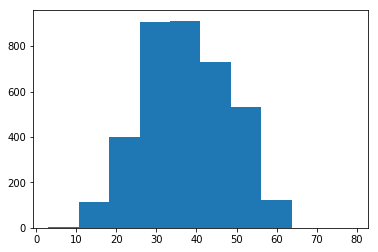

55.0


In [79]:
#full_ns=np.concatenate([train_ns,dev_ns,test_ns],axis=0)
full_ns=[len(i) for i in split_sentences]
plt.hist(full_ns)
plt.show()
print(np.percentile(full_ns,95))

# Pre-Process training, dev, and test sets, Pad Sentences

In [80]:
def make_sentence_list(pre_proc,max_len,sentences):
    sents=[]
    ns=[]
    for sentence in sentences:
        processed_sentence=pre_proc(sentence)
        n=len(processed_sentence)
        if(n<max_len):
            pad_length=max_len-n
            processed_sentence=processed_sentence + ['000'] * pad_length

        sents.append(processed_sentence[0:max_len])
        ns.append(n)

    
    return np.array(sents), np.array(ns)

In [81]:
max_len=55

train_list,train_ns=make_sentence_list(analyze,max_len,train_sentences)
dev_list,dev_ns=make_sentence_list(analyze,max_len,dev_sentences)
test_list,test_ns=make_sentence_list(analyze,max_len,test_sentences)

print(train_list.shape)
print(train_ns.shape)
print(test_list.shape)
print(test_ns.shape)
print(dev_list.shape)
print(dev_ns.shape)

print(train_list[0])

(2608, 55)
(2608,)
(745, 55)
(745,)
(373, 55)
(373,)
['some' 'children' 'therefore' 'enjoy' 'their' 'parents' 'protection'
 'against' 'the' 'loss' 'of' 'income' 'from' 'disability' 'untimely'
 'death' 'or' 'old' 'age' 'and' 'receive' 'benefits' 'that' 'are' 'based'
 'on' 'the' 'same' 'formula' 'used' 'for' 'the' 'old' 'age' 'benefit' '000'
 '000' '000' '000' '000' '000' '000' '000' '000' '000' '000' '000' '000'
 '000' '000' '000' '000' '000' '000' '000']


# Embed The train, test, and dev IBC sentences

In [82]:
def embed_sentences(sentence_array,unknown_word_embedding):
    data=np.zeros([sentence_array.shape[0],sentence_array.shape[1],300])
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            try:
                data[i][j]=model[sentence_array[i][j]]
            except:
                data[i][j]=unknown_word_embedding
    return data
        

In [83]:
unknown_word_embedding=np.random.rand(1,300)

train_data=embed_sentences(train_list,unknown_word_embedding)
dev_data=embed_sentences(dev_list,unknown_word_embedding)
test_data=embed_sentences(test_list,unknown_word_embedding)

print(train_data.shape)
print(dev_data.shape)
print(test_data.shape)


(2608, 55, 300)
(373, 55, 300)
(745, 55, 300)


# Load the Weakly-Annotated All the News Sentences

In [84]:
#minimum score for con_score or lib_score
#if you want no minimum score, make this .5
min_score = .9

atn_sentences=pd.read_csv('ATN_selected_reddit_weak_labels_conlibonly.csv')
atn_sentences = atn_sentences[abs(.5 - atn_sentences['con_score']) > (min_score-.5)]
atn_sentences.head()

,Unnamed: 0,sentence,source,con_score,lib_score,weak_label
0,0,On Tuesday’s broadcast of CNN’s “Situation Roo...,Breitbart,0.999304,0.000696,conservative
10,0,[The Daily Mail reports that the group was abo...,Breitbart,0.983645,0.016355,conservative
12,0,"“Today I was with Suly, my wife (who is a nati...",Breitbart,0.904797,0.095203,conservative
14,0,The Yucatan Times denounced the chanting in an...,Breitbart,0.917745,0.082255,conservative
21,0,"Since 2012, honour crimes reported to the Metr...",Breitbart,0.962279,0.037721,conservative


In [85]:
#for lib/cons predictions
atn_values_dict={'liberal':0,'conservative':1}
atn_sentences['class']=atn_sentences['weak_label'].map(atn_values_dict)
news_sentences=atn_sentences['sentence'].as_matrix()
news_labels=pd.get_dummies(atn_sentences['class']).as_matrix()

print(news_sentences[0:3])
print(news_sentences.shape)
print(news_labels[0:3])
print(news_labels.shape)


[ 'On Tuesday’s broadcast of CNN’s “Situation Room,” CNN Senior Washington Correspondent Jeff Zeleny stated that Chelsea Manning’s transition from a man to a woman “certainly played into” President Obama’s decision to commute Manning’s sentence, and “Without that, it’s hard to imagine, I think, this president would have done that.'
 '[The Daily Mail reports that the group was aboard the Captain Hook Pirate Ship dinner cruise with other revelers when they broke out into the chants, shocking other tourists on board.'
 '“Today I was with Suly, my wife (who is a native of Mexico) watching an entertainment show off the coast of Cancun aboard a boat, and at the end of the show, a flock of Americans (maybe under the influence of alcohol, or maybe not) began to sing the infamous ‘Build that wall’ chant louder and louder,’” he wrote on Facebook.']
(23087,)
[[0 1]
 [0 1]
 [0 1]]
(23087, 2)


# Divide ATN Sentences into Training and Dev Sets - Limit to 20,000 Sentences

In [86]:
shuffle=np.random.permutation(news_sentences.shape[0])
X_atn, y_atn=news_sentences[shuffle][:20000],news_labels[shuffle][:20000]
train_length=int(X_atn.shape[0]*0.8)
X_atn_train,y_atn_train=X_atn[:train_length],y_atn[:train_length]
X_atn_dev,y_atn_dev=X_atn[train_length:],y_atn[train_length:]

train_atn_sentences=X_atn_train.tolist()
train_atn_labels=y_atn_train
dev_atn_sentences=X_atn_dev.tolist()
dev_atn_labels=y_atn_dev



In [87]:
print(train_atn_sentences[0:3])
print(len(train_atn_sentences))
print(train_atn_labels[0:3])
print(train_atn_labels.shape)

print(dev_atn_sentences[0:3])
print(len(dev_atn_sentences))
print(dev_atn_labels[0:3])
print(dev_atn_labels.shape)

['There is no limiting principle other than the subjective desires and (more importantly) the political power of the people making the demands.', 'In September, North Korea said it had hit the button on its fifth and potentially most powerful nuclear test.', 'Dallas Goldtooth, an organizer with the Indigenous Environmental Network and member of the Mdewakanton Dakota and Dine tribes, said he had expected Trump to support the pipeline, but did not imagine it would happen within days of the administration.']
16000
[[0 1]
 [0 1]
 [1 0]]
(16000, 2)
['2 spot,   principal deputy under secretary of defense for policy, as well   as supporting roles covering cyber, space,       and nuclear and missile   defense policy.', 'The insurer reported a 12 percent rise in earnings before payouts to members in its latest quarter, with strength in wealth management, life and health insurance businesses making up for weaker growth in its property and casualty business.', 'Before Harward took himself out of

# Pre-process and Embed the ATN Sentences

In [88]:
train_atn_list, train_atn_ns=make_sentence_list(analyze,max_len,train_atn_sentences)
dev_atn_list, dev_atn_ns=make_sentence_list(analyze,max_len,dev_atn_sentences)

print(train_atn_list.shape)
print(train_atn_ns.shape)
print(dev_atn_list.shape)
print(dev_atn_ns.shape)

(16000, 55)
(16000,)
(4000, 55)
(4000,)


In [89]:
print(train_atn_list[1])

['in' 'september' 'north' 'korea' 'said' 'it' 'had' 'hit' 'the' 'button'
 'on' 'its' 'fifth' 'and' 'potentially' 'most' 'powerful' 'nuclear' 'test'
 '000' '000' '000' '000' '000' '000' '000' '000' '000' '000' '000' '000'
 '000' '000' '000' '000' '000' '000' '000' '000' '000' '000' '000' '000'
 '000' '000' '000' '000' '000' '000' '000' '000' '000' '000' '000' '000']


In [90]:
train_atn_data=embed_sentences(train_atn_list,unknown_word_embedding)
dev_atn_data=embed_sentences(dev_atn_list,unknown_word_embedding)

print(train_atn_data.shape)
print(dev_atn_data.shape)

(16000, 55, 300)
(4000, 55, 300)


# Implement the Confidence Network

In [91]:
from IPython.display import display, clear_output 

50) RMSE = 0.1327


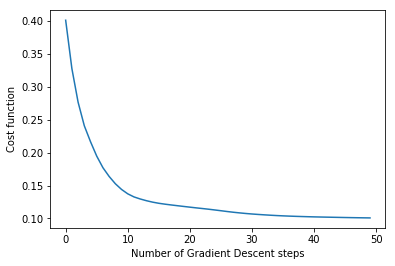

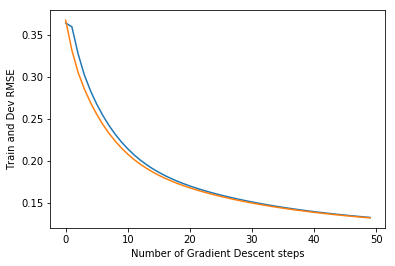

In [92]:
# (1) Parameters
tf.reset_default_graph()
hidden_layer_size=10
learning_rate=.001
batch_size=50
num_ex=train_data.shape[0]

# placeholder
x_=tf.placeholder(tf.float32,shape=[None,max_len,300],name='x')
ns_=tf.placeholder(tf.int32,shape=[None],name='ns')
y_=tf.placeholder(tf.float32,shape=[None],name='y')
is_training_ = tf.placeholder_with_default(True, shape=[], name='is_training')


#define bow encoding layer


def bow_encoding_layer(x_,ns_,is_training=None):
    #zero out padding embedding
    mask_ = tf.expand_dims(tf.sequence_mask(ns_, x_.shape[1],dtype=tf.float32), -1)
    x_=tf.multiply(x_,mask_)
    sum_embeddings=tf.reduce_sum(x_,axis=1)
    return sum_embeddings

#define model with one bow encoding layer, one hidden layer, and one output layer

def model(x_,ns_,hidden_layer_size,is_training=True):
    l1=bow_encoding_layer(x_,ns_)
    l2=tf.layers.dense(inputs=l1,units=hidden_layer_size,activation=tf.tanh)
    output_layer=tf.layers.dense(inputs=l2,units=1,activation=tf.nn.relu)
    return tf.squeeze(output_layer)

#Define training op and optimizer
preds=model(x_,ns_,hidden_layer_size,is_training_)
cc=tf.losses.mean_squared_error(y_,preds)
gd=tf.train.GradientDescentOptimizer(learning_rate)
outputs=tf.identity(preds)

step=gd.minimize(cc)

#Define Error Calculation - RMSE
acc=tf.metrics.mean_squared_error(y_,preds)[1]


#Train the Neural network, report dev/training RMSE
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    cost_vec_avg = []
    acc_dev_vec = []
    acc_train_vec = []
    for i in range(50):
        cost_vec = []
        for start, end in zip(range(0, num_ex, batch_size), range(batch_size, num_ex, batch_size)):
            batch = train_data[start:end], train_labels[start:end]
            ns=train_ns[start:end]
            _, cost = sess.run([step, cc], feed_dict={x_: batch[0],ns_: ns, y_: batch[1], is_training_: True})
            cost_vec.append(cost)

        dev_acc = acc.eval(feed_dict={x_: dev_data,ns_: dev_ns, y_: dev_labels, is_training_: False})
        train_acc = acc.eval(feed_dict={x_: train_data,ns_: train_ns, y_: train_labels,is_training_: False})
        

        
        cost_vec_avg.append(np.mean(cost_vec))
        clear_output(wait=True)
        acc_dev_vec.append(dev_acc)
        acc_train_vec.append(train_acc)
        print('%d) RMSE = %.4f' %(i+1, dev_acc))
       
    #generate predictions for IBC/ATN confidence scores
    probas = preds.eval(feed_dict={x_: train_data,ns_: train_ns, is_training_: False})
    train_atn_probas=preds.eval(feed_dict={x_: train_atn_data,ns_: train_atn_ns, is_training_: False})
    
#plot the results
plt.plot(cost_vec_avg)  
plt.xlabel('Number of Gradient Descent steps')
plt.ylabel('Cost function')
plt.show()

plt.plot(acc_dev_vec)  
plt.plot(acc_train_vec)
plt.xlabel('Number of Gradient Descent steps')
plt.ylabel('Train and Dev RMSE')
plt.show()

In [93]:

print("IBC confidence scores shape:",probas.shape)
print("IBC Confidence scores sample:",probas[0:10])
print('ATN confidence scores shape:',train_atn_probas.shape)
print('ATN confidence scores sample: ',train_atn_probas[0:10])

IBC confidence scores shape: (2608,)
IBC Confidence scores sample: [ 0.58294231  0.54445994  0.57277852  0.66128343  0.65985739  0.56737238
  0.57824546  0.57196236  0.57236159  0.55538255]
ATN confidence scores shape: (16000,)
ATN confidence scores sample:  [ 0.5354647   0.49471679  0.57207596  0.57277769  0.57163978  0.53814137
  0.57472622  0.56996781  0.57276481  0.57278228]


The plot of the train and dev set RMSE doesn't indicate that the confidence network is overfitting the data.

# Examining highest and lowest confidence score sentences

In [94]:
train_atn_probas[np.argsort(train_atn_probas)[:10]]
high = np.argsort(train_atn_probas)[::-1][:10]
low = np.argsort(train_atn_probas)[:10]
sent = np.array(train_atn_sentences)

print('Highest confidence scores:\n')
for index in high:
    print(sent[index])
    print(train_atn_labels[index])
    print(train_atn_probas[index])
    
print('\nLowest confidence scores:\n')
for index in low:
    print(sent[index])
    print(train_atn_labels[index])
    print(train_atn_probas[index])

Highest confidence scores:

patrons volunteer their time assisting with    restaurant chores, which pays for their own meal as well as the tab for their family.
[1 0]
2.07215
A Marine Corps service member is facing a   while another has been discharged following the “Marines United” nude   scandal.
[0 1]
1.89409
Such measures could include suspension or a dorm change so the two parties can avoid contact.
[1 0]
1.84471
Foreign forces, Traditionally dominated by Japanese sportsmen, foreign born sumo wrestlers have outshone their local rivals in recent years.
[0 1]
1.83553
Instead, the legal requirements locked in the instant the student or the student’s parents notified the school that the student’s “gender identity” differed from his or her biological sex.
[0 1]
1.693
“I don’t know that I would get married, but I had met my current husband before I met my first husband.
[0 1]
1.65643
 The company building an oil pipeline that has fueled sustained public protests said on Thursday it has 

# Define Time Change Function.

In [95]:
def pretty_timedelta(since=None, until=None):
    """Pretty-print a timedelta, using the given format string."""
    since = since or time.time()
    until = until or time.time()
    delta_s = until - since
    hours, remainder = divmod(delta_s, 3600)
    minutes, seconds = divmod(remainder, 60)
    #print(hours, minutes, seconds)
    return (hours, minutes, seconds)

# Set Parameters for Target Network

In [96]:
# Hyperparameters
tf.reset_default_graph()
hidden_layer_size = 100
depth_size = 128
filters = [2,3,4]

learning_rate = 0.01
batch_size = 50
num_ex = train_list.shape[0]



pk1 = .9
pk2 = .9
pk3 = .9


num_classes = 2

# placeholders
x_=tf.placeholder(tf.float32,shape=[None, None, None],name='x')
ns_=tf.placeholder(tf.int32,shape=[None],name='ns')
y_=tf.placeholder(tf.int32,shape=[None, None],name='y')
is_training_ = tf.placeholder_with_default(True, shape=[], name='is_training')
c_=tf.placeholder(tf.float32,shape=[None],name='c')
test_y=tf.placeholder(tf.int32,shape=[None])
test_pred=tf.placeholder(tf.int32,shape=[None])

max_time = train_data.shape[1]
embed = train_data.shape[2]


# Define the Model

In [97]:
def CNN(input_x, filters, depth_size, is_training, pk1, max_time, embed):
    """CNN model

    Args:
      input_x: 3-d matrix of sentences converted to word embeddings [batch size, max_length, embed_dim]
      filters: array of filter sizes to use
      depth_size: number of filters of certain size to pass over input
      is_training: boolean that turns on or off dropout

    Returns:
      tensor object after convolutions are applied
    """
    l1 = tf.reshape(input_x, [-1, max_time, embed, 1])
    
    l2 = tf.cond(is_training, 
                 lambda: tf.nn.dropout(l1, pk1),
                 lambda: l1)

    pooled_outputs = []
    
    
    for i, filter_size in enumerate(filters):
        with tf.name_scope("conv-maxpool-%s" % filter_size):
            w1 = tf.get_variable(shape=[filter_size, embed, 1, depth_size], name = 'w1'+str(filter_size))
            l3 = tf.nn.conv2d(l2, w1, [1,1,1,1], 'VALID')
            l4 = tf.nn.relu(l3)
            l5 = tf.nn.max_pool(l4, [1, (max_time-filter_size+1), 1, 1], [1, 1, 1, 1], 'VALID')            
            pooled_outputs.append(l5)


    l5_pool = tf.concat(pooled_outputs, 3)
    l6 = tf.reshape(l5_pool, [-1, (depth_size * len(filters))])
    return l6

def target_model(input_x, filters, depth_size, h, num_classes, is_training, pk1, pk2, pk3, max_time, embed):
    """Total target model that applies convolutions through CCN method and
    then applies fully connected layer and softmax output layer.

    Args:
      input_x: 3-d matrix of sentences converted to word embeddings [batch size, max_length, embed_dim]
      filters: array of filter sizes to use
      depth_size: number of filters of certain size to pass over input
      h: int of hidden dimensions for fully connected layer
      num_classes: output dimensions for softmax layer
      is_training: boolean that turns on or off dropout

    Returns:
      logits of predicted class of sentence classification 
    """
    l6 = CNN(input_x, filters, depth_size, is_training, pk1, max_time, embed)
    
    w2 = tf.get_variable('w2', shape=[depth_size*len(filters), h])
    b2 = tf.get_variable('b2', shape=[h])
    w3 = tf.get_variable('w3', shape=[h, num_classes])
    b3 = tf.get_variable('b3', shape=[num_classes])
    
    l7 = tf.cond(is_training, 
                 lambda: tf.nn.dropout(l6, pk2),
                 lambda: l6)
    l8 = tf.matmul(l7, w2) + b2
    l9 = tf.nn.relu(l8)
    
    l10 = tf.cond(is_training, 
                  lambda: tf.nn.dropout(l9, pk3), 
                  lambda: l9)
    logits = tf.matmul(l10, w3) + b3
    
    return logits

def loss(y, preds, c, is_training):
    """Total target model that applies convolutions through CCN method and
    then applies fully connected layer and softmax output layer.

    Args:
      y: actual labels
      preds: predicted classifications
      c: confidence scores

    Returns:
      training loss
    """

    loss = tf.cond(is_training, 
                  lambda: tf.losses.softmax_cross_entropy(y, preds, weights=c), 
                  lambda: tf.losses.softmax_cross_entropy(y, preds))
        
    return loss

#Define Accuracy calculation

def acc(logits, labels):
    """Total target model that applies convolutions through CCN method and
    then applies fully connected layer and softmax output layer.

    Args:
      logits: predicted logits
      labels: actual labels

    Returns:
      accuracy
    """
    outputs = tf.nn.softmax(logits)
    preds = tf.argmax(outputs, axis=1)
    actuals = tf.argmax(labels, axis=1)
    #acc = tf.metrics.accuracy(actuals, preds)[1]
    comb = [actuals, preds]
    
    
    return comb
   


# Define the methods for the session run

In [98]:
preds = target_model(x_, filters, depth_size, hidden_layer_size, num_classes, is_training_, pk1, pk2, pk3, max_time, embed)
loss = loss(y_, preds, c_, is_training_)
optimizer = tf.train.AdamOptimizer(learning_rate)

step = optimizer.minimize(loss)

#Calculate accuracy
acc=acc(preds,y_)


# Run the Target Network

In [99]:
time.time()

1524446097.7224581

50) Dev Accuracy = 0.7833
50 epochs in 8.81 minutes, 0.0  minutes left


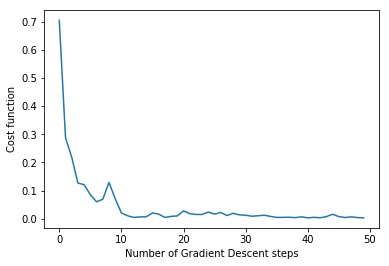

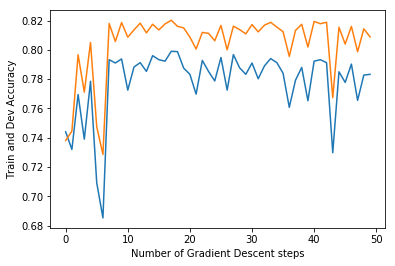

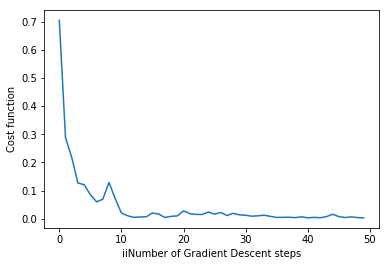

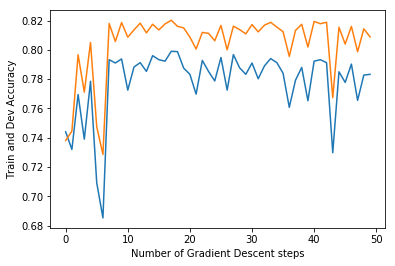

In [100]:
with tf.Session() as sess:
    print('Starting training...')
    start_time = time.time()


    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
   
    
    cost_vec_avg = []
    acc_dev_vec = []
    acc_train_vec = []
    n_epochs = 50
    for i in range(n_epochs):
        cost_vec = []
        for start, end in zip(range(0, num_ex, batch_size), range(batch_size, num_ex, batch_size)):
            
            batch = train_atn_data[start:end], train_atn_labels[start:end]
            c_scores=train_atn_probas[start:end]
            
            _, cost = sess.run([step, loss], feed_dict={x_: batch[0], y_: batch[1], is_training_: True, c_:c_scores})
            cost_vec.append(cost)

        dev_acc = sess.run(acc, feed_dict={x_: dev_atn_data, y_: dev_atn_labels, is_training_: False})
        train_acc = sess.run(acc, feed_dict={x_: train_atn_data, y_: train_atn_labels, is_training_: False})

        cost_vec_avg.append(np.mean(cost_vec))
        clear_output(wait=True)
        acc_dev_vec.append(metrics.accuracy_score(dev_acc[0], dev_acc[1]))
        acc_train_vec.append(metrics.accuracy_score(train_acc[0], train_acc[1]))
        
    
        print('%d) Dev Accuracy = %.4f' %(i+1, metrics.accuracy_score(dev_acc[0], dev_acc[1])))
        time_passed = round((time.time()-start_time)/60, 2)
        time_left = round((n_epochs-(i+1))*((time.time()-start_time)/60)/(i+1), 2)
        print(i+1, 'epochs in', time_passed, 'minutes,', time_left, ' minutes left')
        
        plt.plot(cost_vec_avg)  
        plt.xlabel('Number of Gradient Descent steps')
        plt.ylabel('Cost function')
        plt.show()

        plt.plot(acc_dev_vec)  
        plt.plot(acc_train_vec)
        plt.xlabel('Number of Gradient Descent steps')
        plt.ylabel('Train and Dev Accuracy')
        plt.show()
    
    #get test set accuracy
    test_acc = sess.run(acc, feed_dict={x_: test_data, y_: true_y_test, is_training_: False})
    
    #get test predictions
    predictions = preds.eval(feed_dict={x_: test_data, y_: true_y_test, is_training_: False})
    
    pretty_timedelta(start)

#plot the results
plt.plot(cost_vec_avg)  
plt.xlabel('iiNumber of Gradient Descent steps')
plt.ylabel('Cost function')
plt.show()

plt.plot(acc_dev_vec)  
plt.plot(acc_train_vec)
plt.xlabel('Number of Gradient Descent steps')
plt.ylabel('Train and Dev Accuracy')
plt.show()

# Evaluate Predictions

### Dev set confusion matrix

In [101]:
print(dev_acc[0])
print(dev_acc[1])
metrics.confusion_matrix(dev_acc[0], dev_acc[1])
#predictions

[1 1 0 ..., 0 1 1]
[1 0 1 ..., 0 1 1]


array([[ 542,  496],
       [ 371, 2591]])

### Test Set Performance

In [102]:
preds_binary = np.argmax(predictions, axis=1)
y_binary = np.argmax(true_y_test, axis=1)
print(preds_binary.shape)
print(y_binary.shape)

(745,)
(745,)


In [103]:
print('test set accuracy: ',np.mean(preds_binary==y_binary))

test set accuracy:  0.539597315436


In [104]:
confusion_matrix(y_binary, preds_binary)

array([[259, 148],
       [195, 143]])

In [105]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[244 163]
 [196 142]]


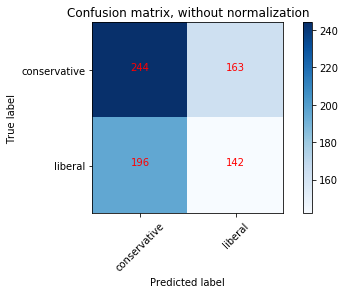

In [53]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_binary, preds_binary)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['conservative', 'liberal'],
                      title='Confusion matrix, without normalization')
plt.show()

# Look for Patterns in Sentence Length and Number of Unknown Words

In [106]:
preds_match=(preds_binary==y_binary).astype(int)

In [107]:
unknown_word_counts=np.zeros(745)
for i in range(unknown_word_counts.shape[0]):
    unknown_word_counts[i]=np.sum(np.mean((test_data[i]==unknown_word_embedding)[:test_ns[i]],axis=1))

print(unknown_word_counts[0:5])

[ 10.   9.   9.   2.   5.]


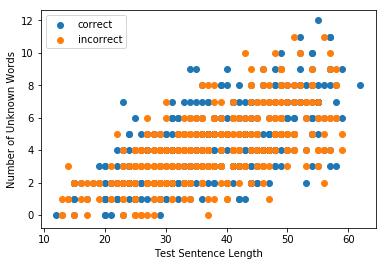

In [108]:
plt.scatter(test_ns[preds_match==1],unknown_word_counts[preds_match==1],label='correct')
plt.scatter(test_ns[preds_match==0],unknown_word_counts[preds_match==0],label='incorrect')
plt.xlabel('Test Sentence Length')
plt.ylabel('Number of Unknown Words')
plt.legend()
plt.show()

The plot above doesn't indicate a clear relationship between either the length of the sentence and the likelihood of a correct prediction, or between the number of unknown words and the likelihood of a correct prediction.  Thus, neither the maximum sentence length nor the choice of embeddings seem to be negatively impacting the accuracy of the model.

# Error analysis: looking at predictions vs. probabilities

In [109]:
#create data frame for predictions and probabilities
pd_data = list(zip(y_binary, preds_binary, [p[0] for p in predictions], [p[1] for p in predictions],[' '.join(s) for s in test_list]))
pred_df = pd.DataFrame(pd_data, columns=['true_label', 'pred_label', 'pred_prob_lib', 'pred_prob_con', 'sentence'])
pred_df['correct'] = pred_df['true_label'] == pred_df['pred_label']
pred_df.head(10)

,true_label,pred_label,pred_prob_lib,pred_prob_con,sentence,correct
0,0,1,-1.132772,3.000260,in response to the setbacks of 2007 immigrants...,False
1,0,0,4.834405,-8.264629,consider the 2011 dearjohn twitter campaign la...,True
2,0,0,7.330924,-14.689532,the strategic projects for progressives are cl...,True
3,1,0,3.642279,-6.501619,even many democrats have acknowledged the dest...,False
4,0,0,6.757044,-10.755880,this is an immensely important change the hist...,True
5,0,1,-0.664954,1.993517,an income tax was proposed around 1815 but wit...,False
6,1,0,4.082848,-5.433874,if they stalk off in anger the employer should...,False
7,1,1,-1.230065,3.347713,as quick as he is to lay blame at bp door obam...,True
8,1,0,4.562924,-7.364097,in the quest to erode barriers to more vibrant...,False
9,1,0,3.736283,-4.600888,george bush has made tax cuts the touchstone o...,False


In [110]:
lib_pred_df = pred_df[pred_df['true_label']==0]
lib_true = lib_pred_df[lib_pred_df['correct']==True]
lib_false = lib_pred_df[lib_pred_df['correct']==False]

con_pred_df = pred_df[pred_df['true_label']==1]
con_true = con_pred_df[con_pred_df['correct']==True]
con_false = con_pred_df[con_pred_df['correct']==False]

In [42]:
# Correctly predicted sentences with highest probability

In [111]:
print('Most liberal sentences:\n')
max_indeces = np.argsort(list(lib_true['pred_prob_lib']))
for i in range(10):
    index = max_indeces[-i-1]
    print(list(lib_true['sentence'])[index])
    print(list(lib_true['pred_prob_lib'])[index], '\n') 

Most liberal sentences:

the dead are victims of free trade and neoliberal economic policies that have destroyed rural communities causing virtual forced march to the and maquiladora sweatshops in hunt for jobs 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000
15.756565094 

the result has been system that according to the national community reinvestment coalition ncrc has since 1977 leveraged over trillion in reinvestment dollars through cra agreements with banks providing credit for affordable housing small businesses economic development and community service facilities in minority and lowand moderate income neighborhoods in both cities and rural areas 000
14.7037258148 

earlier this year an article in the wall street journal on the closure of danish meatpacking plant illustrated how fluid labor markets and generous welfare supports produce virtuous cycle 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 00

In [44]:
print('Most conservative sentences:\n')
max_indeces = np.argsort(list(con_true['pred_prob_con']))
for i in range(10):
    index = max_indeces[-i-1]
    print(list(con_true['sentence'])[index])
    print(list(con_true['pred_prob_con'])[index], '\n') 

Most conservative sentences:

the purchase is stunning in light of the foreknowledge possessed by tsa authorities and their bosses in the obama administration that the scanners simply will not in fact can not detect the weapons whose existence they are using to justify the increase in security and concomitant decrease in personal liberty 000 000 000 000 000
18.7625312805 

whenever responsible gun owners try to enact laws recognizing that potential victims who are in fear of their lives do not need to do everything in their power to escape from criminals before responding to bodily threat with deadly force anti gunners say that such laws are unnecessary 000 000 000 000 000 000 000
15.3394985199 

whether reagan himself was the cold war figure of legend may also be questioned his detestation of nuclear war and readiness to abandon the nuclear force at reykjavik suggest that he was not as hawkish as his liberal detractors depicted 000 000 000 000 000 000 000 000 000 000 000 000 000 000 0

In [45]:
# Incorrectly predicted sentences with highest probability

In [112]:
print('Predicted liberal, but wrong - highest conservative scores:\n')
max_indeces = np.argsort(list(lib_false['pred_prob_con']))
for i in range(10):
    index = max_indeces[-i-1]
    print(list(lib_false['sentence'])[index])
    print(list(lib_false['pred_prob_con'])[index], '\n') 

Predicted liberal, but wrong - highest conservative scores:

cass sunstein sees in american free speech parallel to the moral and conceptual confusion that leads people to complain that taxes are burden because they take my wealth 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000
16.1404056549 

the intersection of the ever faster news cycle unprecedented partisan polarization summer vacation schedules and national security threats hardly makes for rational conversation so it should come as little surprise that one of the very first conservative media responses to the coordinated series of detonations that rocked london on the morning of july was hysterical
16.003780365 

eliminating unneeded weapons systems like the 22 raptor plane the virginia class submarine the dd destroyer and the 22 osprey helicopter could generate more than enough funds to finance needed increases in special forces and peacekeeping missions 000 000 000 00

In [113]:
print('Predicted conservative, but wrong - highest liberal scores:\n')
max_indeces = np.argsort(list(con_false['pred_prob_lib']))
for i in range(10):
    index = max_indeces[-i-1]
    print(list(con_false['sentence'])[index])
    print(list(con_false['pred_prob_lib'])[index], '\n') 

Predicted conservative, but wrong - highest liberal scores:

assuming this trend continues new model unions could very well displace for profit corporations as the dominant entities in the economy thanks to their loyal pools of talent 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000
16.0889225006 

romney supported the tarp bank bailout in 2008 bailout that sparked the tea party movement ire at the use of taxpayers money to bail out few super rich banks that lost risky gambles on real estate market bubble 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000
14.37458992 

the united mine workers saw the agreement as the kiss of death for the coal industry and other industrial unions argued that kyoto would encourage more manufacturers to make the move to china which was exempt from the agreement 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000
13.1895456314 

the popular fallacy of the helpless indi